In [113]:
from tqdm.notebook import tqdm
import pickle
from collections import defaultdict
import numpy as np
from numpy import log, log1p, exp, sqrt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, ttest_1samp
import statsmodels.api as sm

ANN_FACTOR = 52

# Data Load, Statistics

In [114]:
# maybe need to include more than just common stocks... too little data?
with open('./data/stocks.pkl', 'rb') as f:
    stocks = pickle.load(f)

with open('./data/market.pkl', 'rb') as f:
    market = pickle.load(f)

with open('./data/history.pkl', 'rb') as f:
    history = pickle.load(f)

In [115]:
history = sqrt(1 + history) - 1

In [116]:
# Calculate the returns within the bounds for listed and delisted stocks

# # Filter for listed stocks
# listed_stocks = stocks[(stocks['date'] >= lb) & (stocks['date'] < ub)]

# # Filter for delisted stocks (delisted within six months after the upper bound)
# delisted_stocks = stocks[(stocks['ending'] >= ub) & (stocks['ending'] < db)]
most_recent_date = stocks['ending'].max()

# Listed stocks are those that have an ending date after the most recent date in the dataset??
listed_stocks = stocks[stocks['ending'] >= most_recent_date]

# Delisted stocks are those that have an ending date before the most recent date??
delisted_stocks = stocks[stocks['ending'] < most_recent_date]

# Ensure that we are only considering unique tickers for the listed and delisted stocks
listed_tickers = listed_stocks['ticker'].unique()
delisted_tickers = delisted_stocks['ticker'].unique()

listed_stocks = stocks[stocks['ticker'].isin(listed_tickers)]
delisted_stocks = stocks[stocks['ticker'].isin(delisted_tickers)]


# Calculate the descriptive statistics for each category
def calculate_statistics(df, return_type):
    if "ticker" in df.columns:
        no_ind = len(df.ticker.unique())
    else:
        no_ind = 1
    avg_return = round(df[return_type].mean()*100, 3)
    max_return = round(df[return_type].max()*100, 1)
    min_return = round(df[return_type].min()*100, 1)
    
    std_dev = round(df[return_type].std()*100, 3)

    skewness = round(skew(df[return_type]), 2)
    
    kurt = round(kurtosis(df[return_type]), 2)
    
    return (avg_return, max_return, min_return, std_dev, skewness, kurt, no_ind)

# Calculate stats for listed, delisted, and all stocks
stats_listed = calculate_statistics(listed_stocks, "ret")
stats_delisted = calculate_statistics(delisted_stocks, "ret")
stats_all = calculate_statistics(stocks, "ret")

# Calculate stats for the market
stats_market = calculate_statistics(market, "sprtrn")

# Create a dictionary to hold the data
data = {
    'Category': ['Listed Stocks', 'Delisted Stocks', 'All Stocks', 'Market'],
    'Number of Indices': [stats_listed[6], stats_delisted[6], stats_all[6], stats_market[6]],
    'Avg. Return % (Max/Min)': [f"{stats_listed[0]} ({stats_listed[1]} / {stats_listed[2]})",
                                 f"{stats_delisted[0]} ({stats_delisted[1]} / {stats_delisted[2]})",
                                 f"{stats_all[0]} ({stats_all[1]} / {stats_all[2]})",
                                 f"{stats_market[0]} ({stats_market[1]} / {stats_market[2]})"],
    'Avg. SD %':                [f"{stats_listed[3]}",
                             f"{stats_delisted[3]}",
                             f"{stats_all[3]}",
                             f"{stats_market[3]}"],
    'Avg. Skewness':            [f"{stats_listed[4]}",
                                 f"{stats_delisted[4]}",
                                 f"{stats_all[4]}",
                                 f"{stats_market[4]}"],
    'Avg. Kurtosis':            [f"{stats_listed[5]}",
                                 f"{stats_delisted[6]}",
                                 f"{stats_all[5]}",
                                 f"{stats_market[5]}"]
}

# Convert dictionary to DataFrame
descriptive_stats_table = pd.DataFrame(data)

# Print the table to check
descriptive_stats_table


,Category,Number of Indices,Avg. Return % (Max/Min),Avg. SD %,Avg. Skewness,Avg. Kurtosis
0,Listed Stocks,505,0.317 (167.8 / -96.2),4.723,1.09,31.96
1,Delisted Stocks,454,0.229 (161.7 / -99.8),5.759,0.83,454
2,All Stocks,930,0.289 (167.8 / -99.8),5.076,1.01,32.57
3,Market,1,0.181 (15.3 / -18.2),2.29,-0.21,5.28


## Descriptive statistics over annual portfolio returns.

In [117]:
# Convert to cumulative returns
history_cumulative = (1 + history).cumprod()

# Calculate ending value of 1USD
ending_values = history_cumulative.iloc[-1]

# Initialize a dictionary to hold the summary statistics
summary_statistics = {
    'Portfolio': [],
    'Ending Value of 1USD': [],
    'Geometric Average %': [],
    'Arithmetic Average %': [],
    'Standard Deviation %': [],
    'Tracking Error %': []
}

# Calculate summary statistics for each portfolio type (All, Up, Down)
portfolio_types = ['all', 'up', 'down']

for portfolio_type in portfolio_types:
    # Select columns for the current portfolio type and benchmark
    portfolio_cols = [col for col in history.columns if col.startswith(portfolio_type)]
    benchmark_col = f"{portfolio_type}_bench"
    
    for col in portfolio_cols:
        # # Skip the benchmark itself
        # if col == benchmark_col:
        #     continue
        
        # Portfolio returns
        portfolio_returns = history[col]
        
        # Calculate cumulative returns and ending value of 1USD
        cumulative_returns = (1 + portfolio_returns).cumprod()
        ending_value = cumulative_returns.iloc[-1]
        
        # Geometric average return
        geom_avg_return = cumulative_returns.pow(1/len(cumulative_returns)).iloc[-1] - 1
        
        # Arithmetic average return
        arith_avg_return = portfolio_returns.mean()
        
        # Standard deviation of returns
        std_dev = portfolio_returns.std()
        
        # Tracking error relative to benchmark
        tracking_error = (history[col] - history[benchmark_col]).std()
        
        # Append the statistics to the summary
        summary_statistics['Portfolio'].append(col)
        summary_statistics['Ending Value of 1USD'].append(ending_value)
        summary_statistics['Geometric Average %'].append(geom_avg_return * 100)
        summary_statistics['Arithmetic Average %'].append(arith_avg_return * 100)
        summary_statistics['Standard Deviation %'].append(std_dev * 100)
        summary_statistics['Tracking Error %'].append(tracking_error * 100)

# Convert the summary statistics dictionary to a DataFrame
summary_stats_df = pd.DataFrame(summary_statistics)

summary_stats_df


,Portfolio,Ending Value of 1USD,Geometric Average %,Arithmetic Average %,Standard Deviation %,Tracking Error %
0,all_bench,8.463435,5.942161,6.697160,12.628013,0.000000
1,all_0.2,5.459425,4.694264,5.055611,8.590994,7.255061
2,all_0.4,7.824031,5.717473,6.332953,11.287897,3.558571
3,all_0.6,7.502397,5.597602,6.437521,13.163536,2.035907
4,all_0.8,8.966282,6.107548,7.091906,14.448411,2.806236
5,all_1,10.753364,6.630041,8.283013,19.353743,8.571466
6,up_bench,8.463435,5.942161,6.697160,12.628013,0.000000
7,up_0.2,6.452738,5.168329,5.635505,9.720086,5.793851
8,up_0.4,7.322708,5.528437,6.151742,11.357201,3.143122
9,up_0.6,8.417965,5.926738,6.788637,13.366748,2.191289


In [118]:
# Constants
RISK_FREE_RATE = 0.001 / ANN_FACTOR  # Annual risk-free rate adjusted for weekly data

# Initialize a dictionary to store the summary statistics for each portfolio
performance_metrics = []

portfolio_types = ['all', 'up', 'down']

for portfolio_type in portfolio_types:
    # Select columns for the current portfolio type and benchmark
    portfolio_cols = [col for col in history.columns if col.startswith(portfolio_type)]
    benchmark_col = f"{portfolio_type}_bench"

    # Calculate summary statistics for each portfolio type
    for column in portfolio_cols:
        # if column.endswith('bench'):  # Skip benchmark columns
        #     continue
        
        # Portfolio returns
        portfolio_returns = history[column]
        benchmark_returns = history[benchmark_col]
        
        # Calculate excess returns
        excess_returns = portfolio_returns - RISK_FREE_RATE
        excess_benchmark_returns = benchmark_returns - RISK_FREE_RATE

        # Portfolio beta (Placeholder, replace with actual beta values)
        portfolio_beta = 1  # Placeholder value for beta

        # Sharpe Ratio
        sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
        
        # Treynor Ratio (Placeholder, replace with actual beta values)
        treynor_ratio = np.mean(excess_returns) / portfolio_beta
    

        # Jensens_alpha (Placeholder, replace with actual beta values)
        jensens_alpha = np.mean(excess_returns) - portfolio_beta * np.mean(excess_benchmark_returns)


        # Information Ratio
        tracking_error = np.std(portfolio_returns - benchmark_returns)

        if tracking_error != 0: 
            information_ratio = jensens_alpha / tracking_error  

        else:
            information_ratio = np.nan

        # Value at Risk (VaR) and Expected Shortfall (ES) at 95% confidence level
        var = np.percentile(portfolio_returns, 5)
        es = portfolio_returns[portfolio_returns <= var].mean()

        # Add the metrics to the list
        performance_metrics.append({
            'Portfolio': column,
            'Sharpe Ratio': sharpe_ratio,
            'Treynor Ratio': treynor_ratio,
            'Jensen’s Alpha %': jensens_alpha,
            'Information Ratio': information_ratio,
            'Weekly VaR(5%)': var,
            'Weekly ES(5%)': es
        })

# Convert the summary statistics dictionary to a DataFrame
performance_df = pd.DataFrame(performance_metrics)

# Annualize Sharpe and Treynor Ratios by multiplying by the square root of ANN_FACTOR
performance_df['Sharpe Ratio'] = performance_df['Sharpe Ratio']
performance_df['Treynor Ratio'] = performance_df['Treynor Ratio']

# Convert VaR and ES to percentages
performance_df['Weekly VaR(5%)'] *= 100
performance_df['Weekly ES(5%)'] *= 100

# Display the DataFrame
performance_df


,Portfolio,Sharpe Ratio,Treynor Ratio,Jensen’s Alpha %,Information Ratio,Weekly VaR(5%),Weekly ES(5%)
0,all_bench,0.537503,0.066952,0.000000,NaN,-10.860038,-19.694582
1,all_0.2,0.596368,0.050537,-0.016415,-0.229384,-7.300305,-17.522624
2,all_0.4,0.568605,0.063310,-0.003642,-0.103758,-10.248385,-19.005704
3,all_0.6,0.495640,0.064356,-0.002596,-0.129289,-12.750794,-22.806541
4,all_0.8,0.497479,0.070900,0.003947,0.142608,-12.396507,-23.514577
5,all_1,0.433783,0.082811,0.015859,0.187567,-15.879838,-23.467998
6,up_bench,0.537503,0.066952,0.000000,NaN,-10.860038,-19.694582
7,up_0.2,0.587576,0.056336,-0.010617,-0.185766,-9.498409,-18.330486
8,up_0.4,0.548960,0.061498,-0.005454,-0.175921,-11.928220,-20.137917
9,up_0.6,0.514735,0.067867,0.000915,0.042322,-14.303912,-22.433586


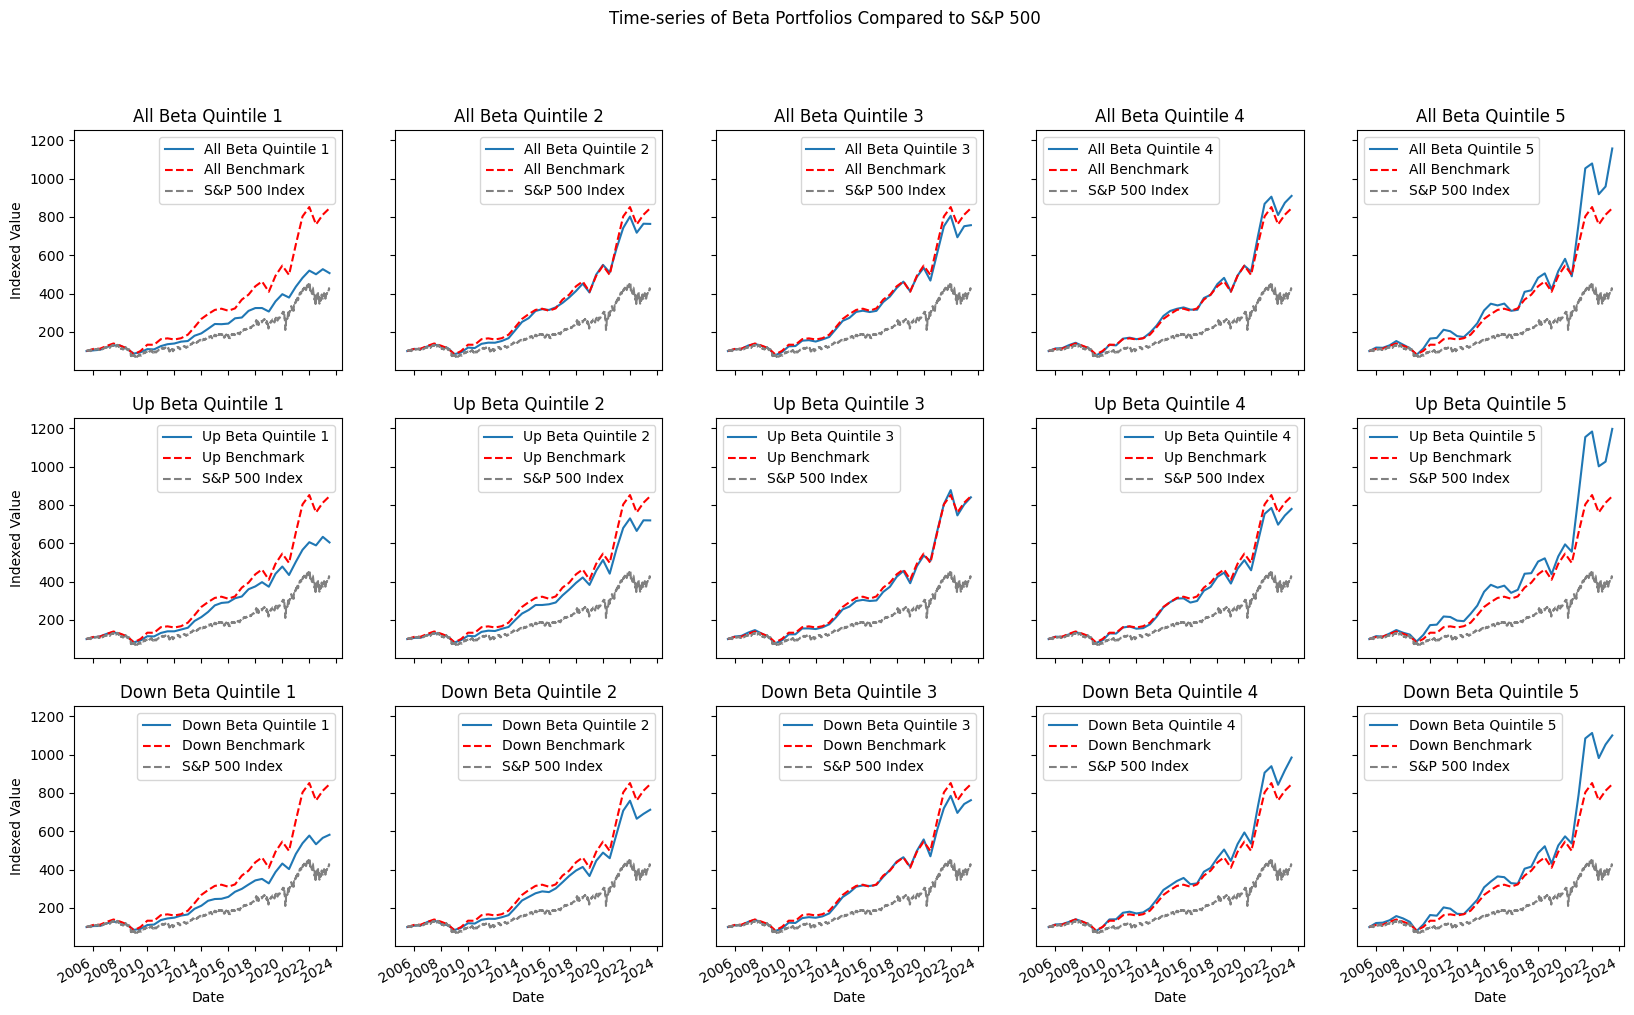

In [119]:
beta_categories = ['All', 'Up', 'Down']
benchmark_suffix = '_bench'

mask = (market.index >= history.index.min()) & (market.index <= history.index.max())
market_trimmed = market[ mask ]
sp500_cumulative = (1 + market_trimmed['sprtrn']).cumprod()
sp500_indexed = 100 * sp500_cumulative / sp500_cumulative.iloc[0]  # Normalize to start at 100

# Prepare the figure for plotting
fig, axes = plt.subplots(nrows=len(beta_categories), ncols=5, figsize=(20, 12), sharex=True, sharey=True)

# Iterate over each beta category and their quintiles
for i, beta_category in enumerate(beta_categories):
    # Extract the portfolio columns for the current beta category
    portfolio_cols = [col for col in history.columns if col.startswith(beta_category.lower()) and not col.endswith(benchmark_suffix)]
    benchmark_col = f"{beta_category.lower()}{benchmark_suffix}"
    
    # Plot each portfolio and its corresponding benchmark
    for j, portfolio_col in enumerate(portfolio_cols):
        ax = axes[i][j]
        # Calculate the cumulative returns for the portfolio
        portfolio_cumulative = (1 + history[portfolio_col]).cumprod()
        benchmark_cumulative = (1 + history[benchmark_col]).cumprod()
        
        # Normalize to start at 100
        portfolio_indexed = 100 * portfolio_cumulative / portfolio_cumulative.iloc[0]
        benchmark_indexed = 100 * benchmark_cumulative / benchmark_cumulative.iloc[0]
        
        # Plot the portfolio and benchmark
        sns.lineplot(portfolio_indexed, label=f'{beta_category} Beta Quintile {j+1}', ax=ax)
        sns.lineplot(benchmark_indexed, label=f'{beta_category} Benchmark', color='red', linestyle='--', ax=ax)
        # Plot the S&P 500 Index for reference
        sns.lineplot(sp500_indexed, label='S&P 500 Index', color='grey', linestyle='--', ax=ax)
        
        ax.set_title(f'{beta_category} Beta Quintile {j+1}')
        ax.legend()

# Set common labels and titles
for ax in axes[-1]:
    ax.set_xlabel('Date')
for i, ax in enumerate(axes[:, 0]):
    ax.set_ylabel('Indexed Value')

plt.suptitle('Time-series of Beta Portfolios Compared to S&P 500')
fig.autofmt_xdate()